## Imports Statments
Importing the Necessary libraries.

In [1]:
# Basic imports
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configure matplotlib for better visuals
plt.style.use('ggplot')
sns.set_context('notebook')

### Load and Construct the Social Network

In [2]:
# Load the Facebook edge list
file_path = 'facebook_combined-1.txt'
edges_df = pd.read_csv(file_path, sep=' ', names=['source', 'target'])

# Initialize the graph
G = nx.from_pandas_edgelist(edges_df, 'source', 'target')

### Basic Network Properties

In [3]:
def basic_network_stats(graph):
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    avg_degree = sum(dict(graph.degree()).values()) / num_nodes
    density = nx.density(graph)

    print(f"Nodes: {num_nodes}")
    print(f"Edges: {num_edges}")
    print(f"Average Degree: {avg_degree:.2f}")
    print(f"Density: {density:.4f}")
    
    return {
        "nodes": num_nodes,
        "edges": num_edges,
        "avg_degree": avg_degree,
        "density": density
    }

network_stats = basic_network_stats(G)

Nodes: 4039
Edges: 88234
Average Degree: 43.69
Density: 0.0108


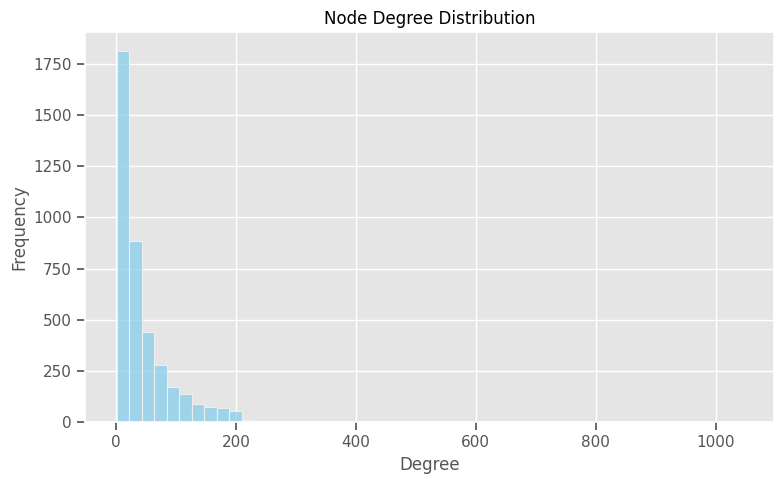

In [22]:
# degree distribution plot
def plot_degree_distribution(graph):
    degrees = [degree for node, degree in graph.degree()]
    plt.figure(figsize=(8, 5))
    sns.histplot(degrees, bins=50, kde=False, color='skyblue')
    plt.title("Node Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_degree_distribution(G)


In [24]:
def network_summary(graph):
    largest_cc = graph.subgraph(max(nx.connected_components(graph), key=len))
    
    summary = {
        'Number of Nodes': graph.number_of_nodes(),
        'Number of Edges': graph.number_of_edges(),
        'Average Degree': round(sum(dict(graph.degree()).values()) / graph.number_of_nodes(), 2),
        'Density': round(nx.density(graph), 4),
        'Number of Connected Components': nx.number_connected_components(graph),
        'Diameter (of largest component)': nx.diameter(largest_cc),
        'Average Clustering Coefficient': round(nx.average_clustering(graph), 4)
    }
    
    return pd.DataFrame(summary.items(), columns=["Metric", "Value"])

# Run the summary
network_summary(G)


,Metric,Value
0,Number of Nodes,4039.0000
1,Number of Edges,88234.0000
2,Average Degree,43.6900
3,Density,0.0108
4,Number of Connected Components,1.0000
5,Diameter (of largest component),8.0000
6,Average Clustering Coefficient,0.6055


### Visualise the Network (Simplified for performance reason)
Tried pyvis but couldn't get it to run

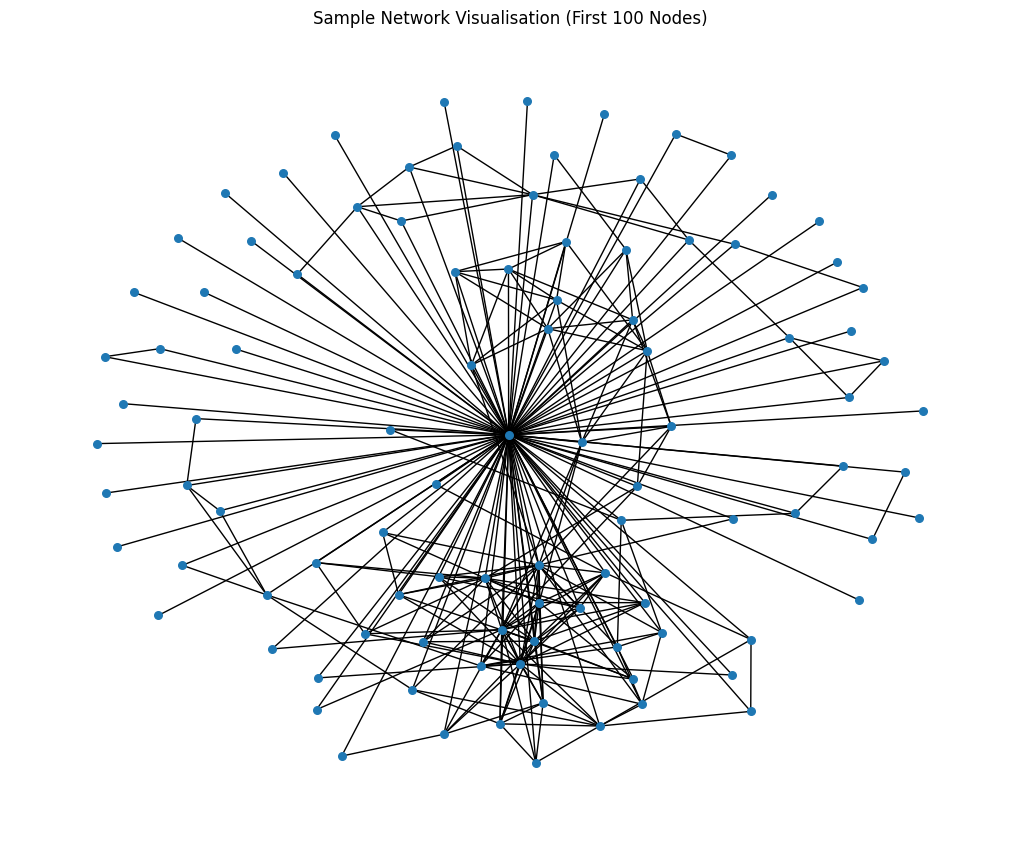

In [12]:
def draw_network_sample(graph, sample_size=100):
    subgraph_nodes = list(graph.nodes())[:sample_size]
    H = graph.subgraph(subgraph_nodes)

    plt.figure(figsize=(10, 8))
    nx.draw(H, node_size=30, with_labels=False)
    plt.title(f"Sample Network Visualisation (First {sample_size} Nodes)")
    plt.show()

draw_network_sample(G)

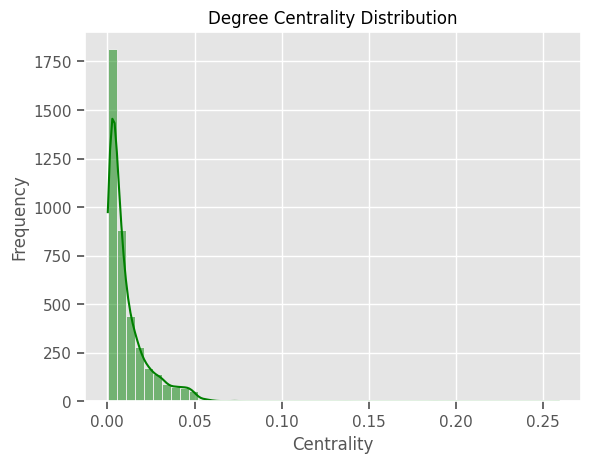

In [25]:
# Calculate and visualise Degree Centrality
def plot_degree_centrality(graph, sample_size=5000):
    subgraph = graph.subgraph(list(graph.nodes())[:sample_size])
    degree_centrality = nx.degree_centrality(subgraph)

    values = list(degree_centrality.values())
    sns.histplot(values, bins=50, kde=True, color='green')
    plt.title("Degree Centrality Distribution")
    plt.xlabel("Centrality")
    plt.ylabel("Frequency")
    plt.show()
    
    return degree_centrality

# Run and store results
node_degree_centrality = plot_degree_centrality(G)


### Edge Betweenness Centrality

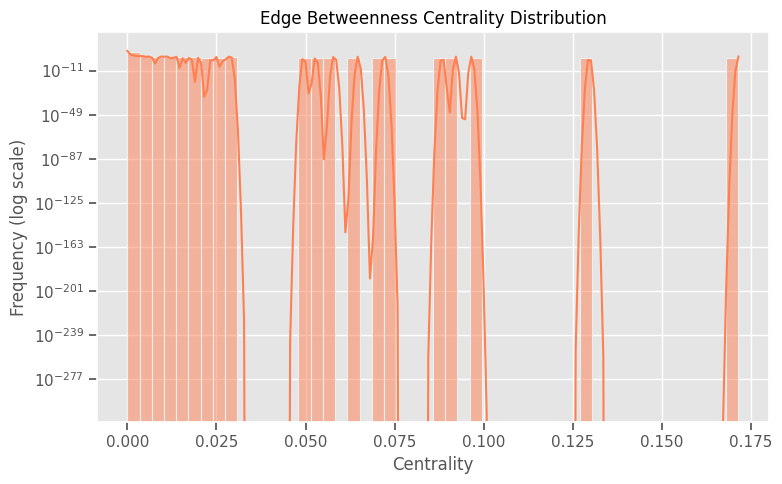

In [14]:
def plot_edge_centrality_distribution(graph, sample_size=5000):
    subgraph = graph.subgraph(list(graph.nodes())[:sample_size])
    centrality = nx.edge_betweenness_centrality(subgraph)

    # Plot
    plt.figure(figsize=(8, 5))
    sns.histplot(list(centrality.values()), bins=50, kde=True, color='coral')
    plt.yscale('log')  # Optional: to better show skewed data
    plt.title("Edge Betweenness Centrality Distribution")
    plt.xlabel("Centrality")
    plt.ylabel("Frequency (log scale)")
    plt.tight_layout()
    plt.show()
    
    return centrality

edge_centrality = plot_edge_centrality_distribution(G)


### Community Detection Algorithms

#### Louvain algorithim

In [16]:
import community as community_louvain
import matplotlib.pyplot as plt
import networkx as nx

# Apply Louvain algorithm
partition = community_louvain.best_partition(G)

# Count the number of communities
num_communities = len(set(partition.values()))
print(f"Louvain method found {num_communities} communities.")


Louvain method found 16 communities.


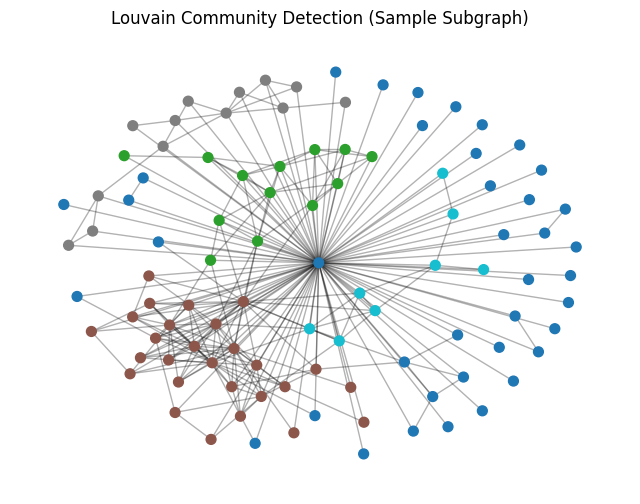

In [17]:
# Sample a subgraph
sample_nodes = list(G.nodes())[:100]
subgraph = G.subgraph(sample_nodes)

# Re-run Louvain on subgraph (optional, for clean visuals)
sample_partition = community_louvain.best_partition(subgraph)

# Draw with community colours
pos = nx.spring_layout(subgraph)
colors = [sample_partition[node] for node in subgraph.nodes()]

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(subgraph, pos, node_color=colors, cmap=plt.cm.tab10, node_size=50)
nx.draw_networkx_edges(subgraph, pos, alpha=0.3)
plt.title("Louvain Community Detection (Sample Subgraph)")
plt.axis('off')
plt.show()

In [18]:
from collections import Counter

community_sizes = Counter(partition.values())
print("Top 5 Largest Communities:")
for comm, size in community_sizes.most_common(5):
    print(f"Community {comm}: {size} nodes")

Top 5 Largest Communities:
Community 9: 548 nodes
Community 5: 545 nodes
Community 1: 454 nodes
Community 3: 425 nodes
Community 4: 423 nodes


#### Greedy Modularity Detection

In [19]:
from networkx.algorithms.community import greedy_modularity_communities

# Sample a subgraph of 1000 nodes
sample_nodes = list(G.nodes())[:1000]
subgraph = G.subgraph(sample_nodes)

# Apply the greedy algorithm
greedy_communities = list(greedy_modularity_communities(subgraph))

# Number of communities detected
print(f"Greedy modularity found {len(greedy_communities)} communities.")


Greedy modularity found 9 communities.


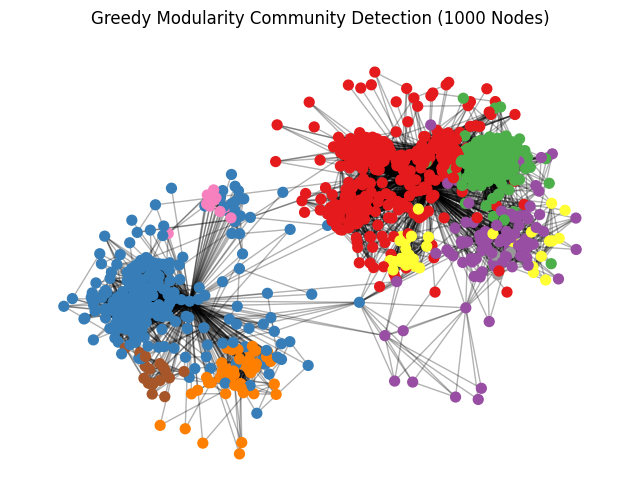

In [20]:
# Map nodes to community index for color plotting
community_map = {}
for i, community in enumerate(greedy_communities):
    for node in community:
        community_map[node] = i

# Use spring layout and assign colors
pos = nx.spring_layout(subgraph, seed=42)
colors = [community_map[node] for node in subgraph.nodes()]

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(subgraph, pos, node_color=colors, cmap=plt.cm.Set1, node_size=50)
nx.draw_networkx_edges(subgraph, pos, alpha=0.3)
plt.title("Greedy Modularity Community Detection (1000 Nodes)")
plt.axis('off')
plt.show()